In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
from astropy.time import Time
import sys
from astropy.io import fits

from tqdm import *

figures=1
plotdir='/home/ramain/packages/rmainpapers/CrabWB/Figures/'

%matplotlib inline

In [2]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def ReadPulselist(f, SNcut=1, phase0=0.5, phasewidth=0.5):
    T, SN, phase = np.loadtxt(f, dtype='string').T
    
    T = Time(T, precision=9)

    Tu, indeces = np.unique(T.isot, return_index=True)

    T = Time(Tu, precision=9)
    SN = SN[indeces].astype('float')
    phase = phase[indeces].astype('float')

    T = T[SN>SNcut]
    phase = phase[SN>SNcut]
    SN = SN[SN>SNcut]

    T = T[abs(phase-phase0) < phasewidth]
    SN = SN[abs(phase-phase0) < phasewidth]
    phase = phase[abs(phase-phase0) < phasewidth]

    return T, SN, phase

def ExtractPulse(tgp):
    dchan = np.load('/media/drive2/GPs16/GP{0}.npy'.format(tgp.isot))
    #prof = rechannelize(dchan, 32)
    #peak = np.argmax(np.abs(prof).sum(-1).sum(-1))
    #prof = np.roll(prof, prof.shape[0]//2 - peak, axis=0)
    #dchan = rechannelize(prof, 128) 
    
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    x = (abs(dR)**2 + abs(dL)**2)
    
    pulse = x[50]
    noise = x[5:35]#.mean(0)
    bg = x[19:22].mean(0)

    GP = pulse# - bg 
    n = noise# - bg
    return GP[16:-16], noise[:,16:-16]

def ExtractArPulse(tgp):
    dchan = np.load('/media/drive2/ArGPs/GP{0}.npy'.format(tgp.isot))
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    x = (abs(dR)**2 + abs(dL)**2)
    pulse = x[49:52].mean(0)
    noise = x[9:40]#.mean(0)
    bg = x[19:22].mean(0)
    GP = pulse# - bg 
    n = noise# - bg
    return GP[16:-16], bg[16:-16]

def ExtractBWPulse(tgp):
    dchan = np.load('/media/drive2/b1957-GPs/RGPs/GP{0}.npy'.format(tgp.isot))
    x = (abs(dchan)**2)
    pulse = x[49:51].mean(0)
    noise = x[9:11].mean(0)
    bg = x[10:13].mean(0)

    GP = pulse
    n = noise
    return GP[50:-50], noise[50:-50]

def CorrPulses(GP1, N1, GP2, N2):
    autoc = (GP1 - np.mean(GP1))  * (GP2 - np.mean(GP2))

    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    #std1 = np.std(GP1)**2.0 - np.mean(N1**2.0)
    #std2 = np.std(GP2)**2.0 - np.mean(N2**2.0)

    corr = np.mean( autoc / np.sqrt(std1 * std2))
    return corr

def FreqCorr1(GP1, N1, GP2, N2):
    N = len(GP1)
    ccorr = np.zeros(N)
    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    for i in range(N):
        GP2roll = np.roll(GP2, i)
        autoc = (GP1 - np.mean(GP1))  * (GP2roll - np.mean(GP2))
        corr = np.mean( autoc / np.sqrt(std1 * std2))        
        ccorr[i] = corr 
    return ccorr
    
def FreqCorr(GP1, N1, GP2, N2):
    N = len(GP1)
    ccorr = np.zeros(N)
    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    autoc = np.fft.irfft( np.fft.rfft(GP1 - np.mean(GP1))  * np.fft.rfft(GP2 - np.mean(GP2)).conj() )
    ccorr = autoc / np.sqrt(std1 * std2) / N
    return ccorr
    
def CorrNoise(GP1, GP2, M, V):
    # On pulse, off pulse, and cross-term in variance
    
    meanbg = M
    varbg =  V

    mean1 = np.mean(GP1)
    var1 = np.std(GP1)**2.0
    varct1 = 2*(mean1 - meanbg)*meanbg
    
    var1_corrected = var1 - varbg - varct1
    
    mean2 = np.mean(GP2)
    var2 = np.std(GP2)**2.0 
    varct2 = 2*(mean2 - meanbg)*meanbg
    
    var2_corrected = var2 - varbg - varct2
    
    autoc = (GP1 - mean1)  * (GP2 - mean2)
    corr = np.mean( autoc / np.sqrt(var1_corrected * var2_corrected))
    
    return corr
    
def CCorrNoise(GP1, GP2, M, V):
#def CCorrNoise(GP1, GP2, N1, N2):
    N = len(GP1)
    ccorr = np.zeros(N)
    # On pulse, off pulse, and cross-term in variance
  
    meanbg = M
    varbg =  V
    #meanbg = np.mean(N1)
    #varbg = np.std(N1)
    
    mean1 = np.mean(GP1)
    var1 = np.std(GP1)**2.0
    varct1 = 2*(mean1 - meanbg)*meanbg
    
    var1_corrected = var1 - varbg - varct1
    
    mean2 = np.mean(GP2)
    var2 = np.std(GP2)**2.0 
    varct2 = 2*(mean2 - meanbg)*meanbg
    
    var2_corrected = var2 - varbg - varct2
    
    for i in range(N):
        GP2roll = np.roll(GP2, i)
        autoc = (GP1 - mean1)  * (GP2 - mean2)
        
        corr = np.mean( autoc / np.sqrt(var1_corrected * var2_corrected))
        ccorr[i] = corr
    
    weight = var1_corrected * var2_corrected
    
    return ccorr, weight
    
def weight_model(WeightSim, SN):
    SimSN = WeightSim[:,0]
    SimErr = WeightSim[:,1]
    Errors = np.zeros_like(SN)
    for i in range(len(SN)):
        sn = SN[i]
        index = (np.abs(SimSN-sn)).argmin()
        Errors[i] = SimErr[index]
    return Errors

def rebin(dyn, nt=1, nf=1):
    if nt > 1:
        dyn = dyn.reshape(-1,nt,dyn.shape[1]).mean(axis=1)
    if nf > 1:
        mid = dyn.shape[1]//2
        
        dynf = dyn[:,  ]
        dyn = dyn.reshape(dyn.shape[0],-1,nf).mean(axis=-1)
    return dyn

In [3]:
""" 
Load Correlation Arrays for Plotting Purposes, and sim histograms

MP, IP corrs used for Figure 3, 4
"""

%matplotlib inline

y = fits.open('CrabSimPars.fits')
print y.info()

MPplot = y[1].data
IPplot  = y[2].data
sims = y[3].data
IPsims = y[4].data

MPplot_clean = MPplot - ( MPplot[-20:].mean(axis=0) + MPplot[:20].mean(axis=0) ) / 2.
IPplot_clean = IPplot - ( IPplot[-10:].mean(axis=0) + IPplot[:10].mean(axis=0) ) / 2.

# bin for plotting purposes
#MPplot_clean=rebin(MPplot_clean, nf=2, nt=2)

# Horrible workaround to rebin while keeping zero frequency
mid = MPplot_clean.shape[1]//2
dyn_mid = MPplot_clean[:,mid]
MPbin = np.delete(MPplot_clean, mid, axis=1)
MPbin = rebin(MPbin[:,1:-1], nt=1, nf=2)
MPplot_clean = np.concatenate((MPbin[:,:mid//2], dyn_mid[:, np.newaxis], MPbin[:,mid//2:]), axis=1)

mid = IPplot_clean.shape[1]//2
dyn_mid = IPplot_clean[:,mid]
IPbin = np.delete(IPplot_clean, mid, axis=1)
IPbin = rebin(IPbin[:,1:-1], nt=1, nf=2)
IPplot_clean = np.concatenate((IPbin[:,:mid//2], dyn_mid[:, np.newaxis], IPbin[:,mid//2:]), axis=1)
#MPplot_clean=rebin(MPplot_clean, nf=1)
#IPplot_clean=rebin(IPplot_clean, nf=1)

NF = MPplot_clean.shape[1]
MT = MPplot_clean.shape[0]
IT = IPplot_clean.shape[0]


Filename: CrabSimPars.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1    MP CROSS-CORR  ImageHDU         8   (223, 121)   float64   
2    IP CROSS-CORR  ImageHDU         8   (223, 61)    float64   
3    MP SIM FITS  ImageHDU         8   (5, 10240)   float64   
4    IP SIM FITS  ImageHDU         7   (5,)         float64   
None


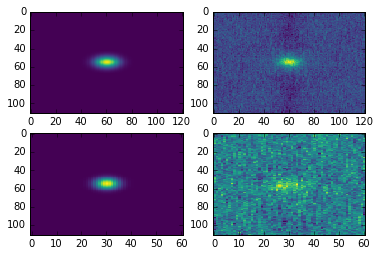

In [59]:
""" 2D GAUSSIAN FIT FOR MP, IP WEIGHTING"""

def gaussian2D((t, nu), A, t0, tsig, nu0, nusig):
    g =  A * np.exp(-(t-t0)**2.0 / (2*tsig**2.0)) * np.exp(-(nu-nu0)**2.0 / (2*nusig**2.0))
    return g.T.ravel()
    
import scipy.optimize as so

p0 = [0.01, 0, 10, 0, 1]

MPb = np.array(MPplot_clean)
IPb = np.array(IPplot_clean)

t = np.linspace(-60,60,MPb.shape[0])
nu = np.linspace(-14,14,MPb.shape[1])
tp, nup = np.meshgrid(t,nu)
data = MPb.ravel()
b, berr = so.curve_fit(gaussian2D, (tp, nup), data, p0=p0)

MPmodel = gaussian2D((tp, nup), b[0], b[1], b[2], b[3], b[4])
MPmodel = MPmodel.reshape(MPb.shape)

t = np.linspace(-60,60,IPb.shape[0])
nu = np.linspace(-14,14,IPb.shape[1])
tp, nup = np.meshgrid(t,nu)
#data = IPb.ravel()
#b, berr = so.curve_fit(gaussian2D, (tp, nup), data, p0=p0)

IPmodel = gaussian2D((tp, nup), b[0], b[1], b[2], b[3], b[4])
IPmodel = IPmodel.reshape(IPb.shape)

plt.subplot(221)
plt.imshow(MPmodel.T)

plt.subplot(222)
plt.imshow(MPb.T)

plt.subplot(223)
plt.imshow(IPmodel.T)

plt.subplot(224)
plt.imshow(IPb.T)

In [64]:
hwfact = np.sqrt(2*np.log(2))
thwhm = b[2]*hwfact
thwhm_width = berr[2][2]*hwfact

print b

fhwhm = b[4]*hwfact
fhwhm_width = berr[4][4]*hwfact


print thwhm, thwhm_width
print fhwhm, fhwhm_width

[  2.23440632e-02   2.48838405e-04   6.37364724e+00   1.22077434e-03
   1.00814961e+00]
7.50439614016 0.00724406045881
1.1870054592 0.000181236687975


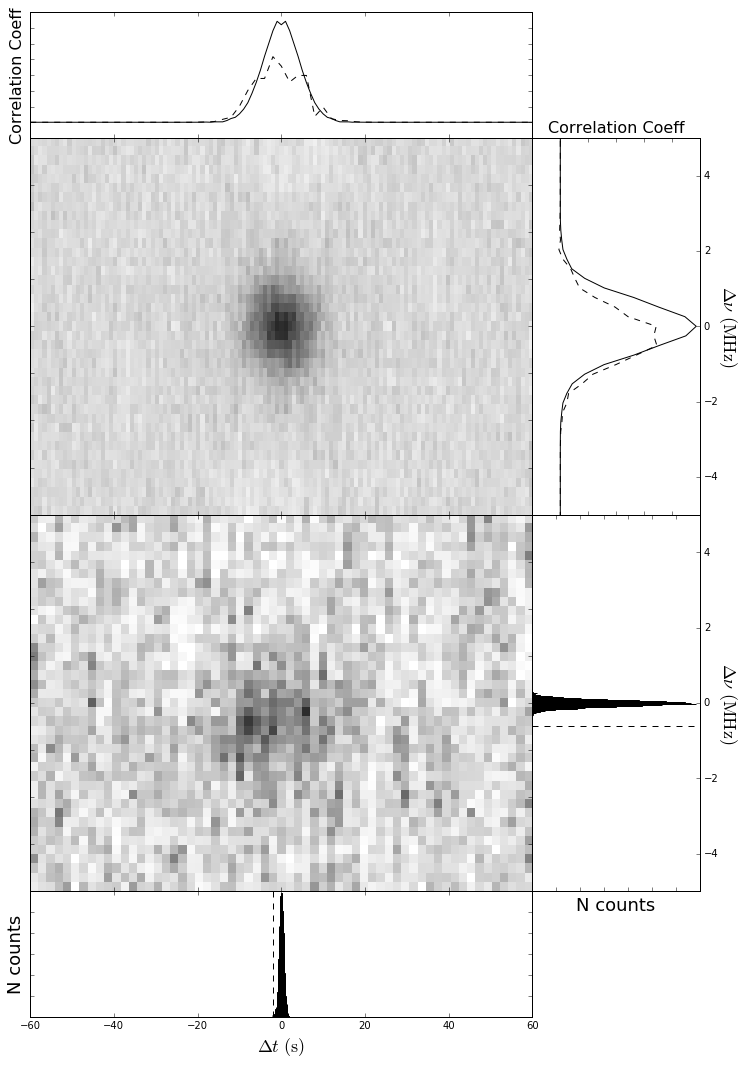

In [5]:
""" Big Mosaic of Pulse Correlations """

frange = 20

MPtplot = np.linspace(-60,60, MPplot_clean.shape[0])
IPtplot = np.linspace(-60,60, IPplot_clean.shape[0])

MPfplot = np.linspace(-14,14, MPplot_clean.shape[1])
IPfplot = np.linspace(-14,14, IPplot_clean.shape[1])

f = plt.figure(figsize=(12,18))

ax1 = plt.subplot2grid((8,4), (0,0), colspan=3)
ax2 = plt.subplot2grid((8,4), (1,0), colspan=3, rowspan=3)
ax3 = plt.subplot2grid((8,4), (4,0), colspan=3, rowspan=3)
ax4 = plt.subplot2grid((8,4), (7,0), colspan=3)
ax5 = plt.subplot2grid((8,4), (1,3), rowspan=3)
ax6 = plt.subplot2grid((8,4), (4,3), rowspan=3)

f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:3]], visible=False)
plt.setp([a.get_xticklabels() for a in f.axes[-2:]], visible=False)

plt.setp([a.get_yticklabels() for a in f.axes[:-2]], visible=False)

ax2.imshow( MPplot_clean[:, NF//2-frange:NF//2+frange+1].T, aspect='auto', interpolation='nearest', 
           cmap=cm.Greys, extent=[-60,60,-4,4], vmin=-0.01, vmax=0.03)
ax3.imshow( IPplot_clean[:,NF//2-frange:NF//2+frange+1].T, aspect='auto', interpolation='nearest', 
           cmap=cm.Greys, extent=[-60,60,-4,4], vmin=-0.01, vmax=0.03)

# Remove nyquist frequency
MP_timeproj = (MPplot_clean * MPmodel).mean(-1)
MP_freqproj = (MPplot_clean * MPmodel).mean(0)
IP_timeproj = (IPplot_clean * IPmodel).mean(-1)
IP_freqproj = (IPplot_clean * IPmodel).mean(0)

ax1.plot(MPtplot, MP_timeproj, 'k-')
ax1.plot(IPtplot, IP_timeproj, 'k--')
ax1.set_ylabel(r'Correlation Coeff', fontsize=16)
ax1.yaxis.set_label_position('left')

#ax4.plot(MPtplot, MP_timeproj, 'k--')

ax4.hist(sims[:,0], bins=100, label='%s MP sims' % (10240), color='grey')
ax4.axvline(IPsims[0], linestyle='--', color='k', label='IP')

ax4.set_xlabel(r'$\Delta t\ \mathrm{(s)}$', fontsize=18)
ax4.set_ylabel(r'N counts', fontsize=18)
ax4.set_xlim(-60,60)

ax5.plot(MP_freqproj[NF//2-frange:NF//2+frange+1][::-1], MPfplot[NF//2-frange:NF//2+frange+1], 'k-')
ax5.plot(IP_freqproj[NF//2-frange:NF//2+frange+1][::-1], IPfplot[NF//2-frange:NF//2+frange+1], 'k--')
#ax6.plot(MP_freqproj[NF//2-20:NF//2+20][::-1], MPfplot[NF//2-20:NF//2+20], 'k--')

ax5.yaxis.tick_right()
ax6.yaxis.tick_right()
ax5.set_ylabel(r'$\Delta \nu\ \mathrm{(MHz)}$', fontsize=18, labelpad=20, rotation=270)
ax6.set_ylabel(r'$\Delta \nu\ \mathrm{(MHz)}$', fontsize=18, labelpad=20, rotation=270)
ax5.yaxis.set_label_position('right')
ax6.yaxis.set_label_position('right')
ax5.set_ylim(-5,5)
ax6.set_ylim(-5,5)

ax5.set_xlabel(r'Correlation Coeff', fontsize=16)
ax6.set_xlabel(r'N counts', fontsize=18)
ax5.xaxis.set_label_position('top')
ax6.xaxis.set_label_position('bottom')

ax6.hist(-sims[:,1], bins=100, label='%s MP sims' % (10240), color='grey', orientation='horizontal')
ax6.axhline(-IPsims[1], linestyle='--', color='k', label='IP')
#plt.legend()
#plt.text(-1, 850, r'$\mathrm{\Delta t} \mathrm{(s)}$', fontsize=18)
#plt.ylim(0,1000)


if figures:
    plt.savefig('%sACF.pdf' % (plotdir))
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


(600, 128)


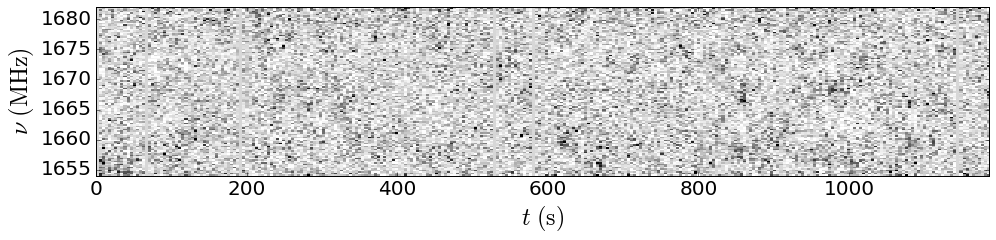

In [6]:
f = np.load('/home/ramain/packages/scint_analysis/crab_WB/MPdyn4sbin.npy')
ic = np.load('/home/ramain/packages/scint_analysis/crab_WB/MPnoise4sbin.npy')
%matplotlib inline

MPdyn = (f - f.mean(axis=1, keepdims=True)) / f.std(axis=1, keepdims=True)
MPdyn[np.isnan(MPdyn)]=0
plt.figure(figsize=(16,6))

MPdyn_bin = MPdyn.reshape(MPdyn.shape[0],-1,2).mean(-1)
MPdyn_bin = MPdyn_bin[:1200].reshape(-1,2, MPdyn_bin.shape[1]).mean(1)

plot_range = slice(440-141, 592)

print MPdyn_bin.shape

plt.imshow(MPdyn_bin[plot_range, 8:-8].T, interpolation='nearest', cmap=cm.Greys, vmin=-0.7, vmax=2.0,
           aspect='8', extent=[0,1200-(14),1652+2,1652+32 - 2])
#[900+300:900+600-10]

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlabel(r'$t\ \mathrm{(s)}$', fontsize=24)
plt.ylabel(r'$\nu\ \mathrm{(MHz)}$', fontsize=24)

if figures:
    plt.savefig('%sMPdyn.pdf' % (plotdir),  dpi=1000)

(121, 223)


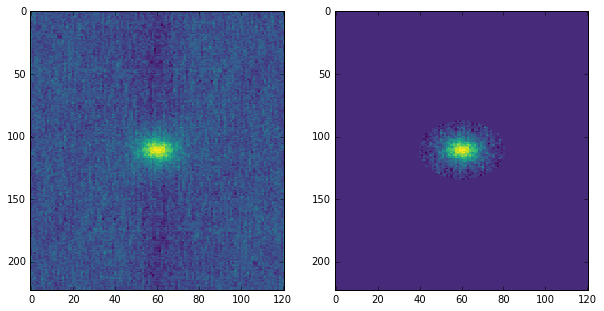

In [66]:
""" Secondary Spectra from Cross-Correlations """
    
plt.figure(figsize=(10,5))
    
#MPplot = np.load('MPcorr-SN1.npy')
MPplot_clean = MPplot - ( MPplot[-20:].mean(axis=0) + MPplot[:20].mean(axis=0) ) / 2.

print MPplot.shape

p0 = [0.01, 0, 10, 0, 1]

MPb = np.array(MPplot_clean)

t = np.linspace(-60,60,MPb.shape[0])
nu = np.linspace(-14,14,MPb.shape[1])

tp, nup = np.meshgrid(t,nu)
data = MPb.ravel()
b, berr = so.curve_fit(gaussian2D, (tp, nup), data, p0=p0)

MPmodel = gaussian2D((tp, nup), b[0], b[1], b[2], b[3], b[4])
MPmodel = MPmodel.reshape(MPb.shape)

plt.subplot(121)
plt.imshow(MPplot_clean.T)

sig = np.std(MPplot_clean[:50,:50])

corr_mask = np.where(MPmodel < 0.1*sig)

MPmodel_masked = np.array(MPmodel)
MPmodel_masked[corr_mask] = 0
MP_masked = np.array(MPplot_clean)
MP_masked[corr_mask] = 0

plt.subplot(122)
plt.imshow(MP_masked.T)

(121, 223)
(121, 223)


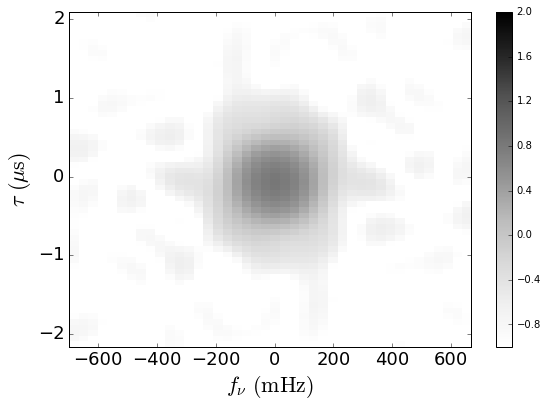

In [67]:
#SS = np.fft.fft2(MPplot_clean)
MP_SS = np.fft.fftshift(MP_masked)

print MP_masked.shape

SS = np.fft.fft2(MP_SS)
SS = np.fft.fftshift(SS)

print MPplot_clean.shape

Tbin=0.5*u.s 
fbin=16.*u.MHz/128

taumax = (1 / fbin).to(u.microsecond).value
fnumax = (1 / Tbin).to(u.mHz).value

fnu = np.linspace(-fnumax, fnumax, SS.shape[0])
tau = np.linspace(-taumax, taumax, SS.shape[1])

fnu_centre = SS.shape[0] // 2
tau_centre = SS.shape[1] // 2

dtau = 30
dfnu = 21

fnu_slice = slice(fnu_centre-dfnu, fnu_centre+dfnu)
tau_slice = slice(tau_centre-dtau, tau_centre+dtau)

plt.figure(figsize=(9,6))
plt.imshow(np.log10(abs(SS[fnu_slice, tau_slice])).T, interpolation='nearest', cmap = cm.Greys, 
           vmin=-1.0, vmax=2.0,
           aspect='auto', extent=[fnu[fnu_slice][0], fnu[fnu_slice][-1], tau[tau_slice][0], tau[tau_slice][-1]])
plt.colorbar()

plt.xlabel(r'$f_{\nu}\ \mathrm{(mHz)}$', fontsize=22)
plt.ylabel(r'$\tau \ \mathrm{(\mu s)}$', fontsize=22)

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

if figures:
    plt.savefig('%sSS.pdf' % (plotdir))

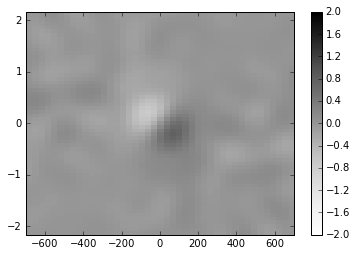

In [59]:
plt.imshow(np.imag(SS[fnu_slice, tau_slice]).T, interpolation='nearest', cmap = cm.Greys, aspect='auto',
          extent=[fnu[fnu_slice][0], fnu[fnu_slice][-1], tau[tau_slice][0], tau[tau_slice][-1]],
          vmax=2, vmin=-2)
plt.colorbar()

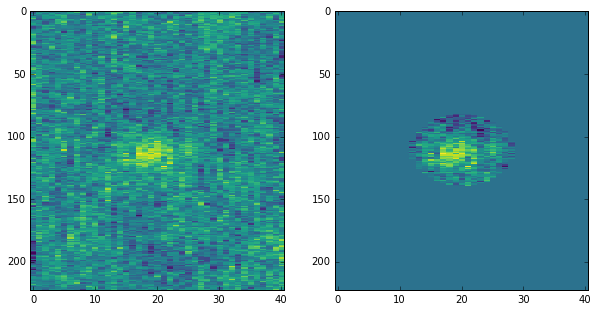

In [68]:
plt.figure(figsize=(10,5))

#IPplot = np.load('IPcorr-SN1.npy')
IPplot_clean = IPplot - ( MPplot[-20:].mean(axis=0) + MPplot[:20].mean(axis=0) ) / 2.

t = np.linspace(-60,60,IPplot_clean.shape[0])
nu = np.linspace(-14,14,IPplot_clean.shape[1])
tp, nup = np.meshgrid(t,nu)

IPmodel = gaussian2D((tp, nup), b[0], b[1], b[2], b[3], b[4])
IPmodel = IPmodel.reshape(IPplot_clean.shape)

plt.subplot(121)
plt.imshow(IPplot_clean.T)

sig = np.std(MPplot_clean[:50,:50])
corr_mask = np.where(IPmodel < 0.01*sig)

IP_masked = np.array(IPplot_clean)
IP_masked[corr_mask] = 0

plt.subplot(122)
plt.imshow(IP_masked.T)

(121, 223)
[ -3.33333333e+02  -3.16666667e+02  -3.00000000e+02  -2.83333333e+02
  -2.66666667e+02  -2.50000000e+02  -2.33333333e+02  -2.16666667e+02
  -2.00000000e+02  -1.83333333e+02  -1.66666667e+02  -1.50000000e+02
  -1.33333333e+02  -1.16666667e+02  -1.00000000e+02  -8.33333333e+01
  -6.66666667e+01  -5.00000000e+01  -3.33333333e+01  -1.66666667e+01
  -5.68434189e-14   1.66666667e+01   3.33333333e+01   5.00000000e+01
   6.66666667e+01   8.33333333e+01   1.00000000e+02   1.16666667e+02
   1.33333333e+02   1.50000000e+02   1.66666667e+02   1.83333333e+02
   2.00000000e+02   2.16666667e+02   2.33333333e+02   2.50000000e+02
   2.66666667e+02   2.83333333e+02   3.00000000e+02   3.16666667e+02
   3.33333333e+02]


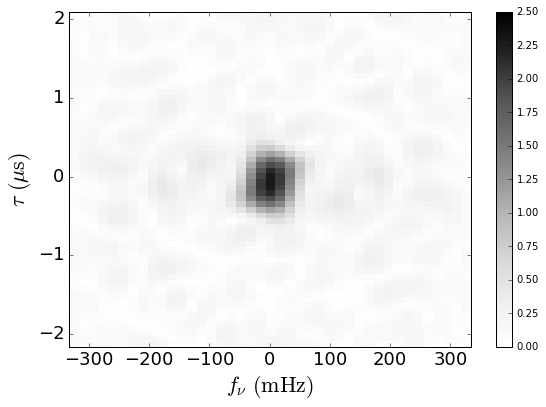

In [69]:
#SS = np.fft.fft2(IPplot_clean)
IP_SS = np.fft.fftshift(IP_masked)
SS = np.fft.fft2(IP_SS)
SS = np.fft.fftshift(SS)

print MPplot_clean.shape

Tbin=3*u.s 
fbin=16.*u.MHz/128

taumax = (1 / fbin).to(u.microsecond).value
fnumax = (1 / Tbin).to(u.mHz).value

fnu = np.linspace(-fnumax, fnumax, SS.shape[0])
tau = np.linspace(-taumax, taumax, SS.shape[1])

fnu_centre = SS.shape[0] // 2
tau_centre = SS.shape[1] // 2

dtau = 30
dfnu = 300

fnu_slice = slice(fnu_centre-dfnu, fnu_centre+dfnu)
print fnu
tau_slice = slice(tau_centre-dtau, tau_centre+dtau)

plt.figure(figsize=(9,6))
plt.imshow(abs(SS[fnu_slice, tau_slice]).T, interpolation='nearest', 
           cmap = cm.Greys, aspect='auto', vmin=-0.0, vmax=2.5,
          extent=[fnu[fnu_slice][0], fnu[fnu_slice][-1], tau[tau_slice][0], tau[tau_slice][-1]])
plt.colorbar()

plt.xlabel(r'$f_{\nu}\ \mathrm{(mHz)}$', fontsize=22)
plt.ylabel(r'$\tau \ \mathrm{(\mu s)}$', fontsize=22)

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

if figures:
    plt.savefig('%sIPSS.pdf' % (plotdir))

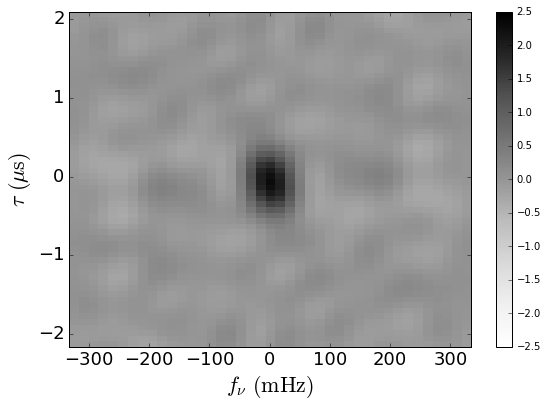

In [70]:
plt.figure(figsize=(9,6))

plt.imshow(np.real(SS[fnu_slice, tau_slice]).T, interpolation='nearest', cmap = cm.Greys, aspect='auto',
          extent=[fnu[fnu_slice][0], fnu[fnu_slice][-1], tau[tau_slice][0], tau[tau_slice][-1]],
          vmax=2.5, vmin=-2.5)
plt.colorbar()

plt.xlabel(r'$f_{\nu}\ \mathrm{(mHz)}$', fontsize=22)
plt.ylabel(r'$\tau \ \mathrm{(\mu s)}$', fontsize=22)

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

if figures:
    plt.savefig('%sIPSS-real.pdf' % (plotdir))

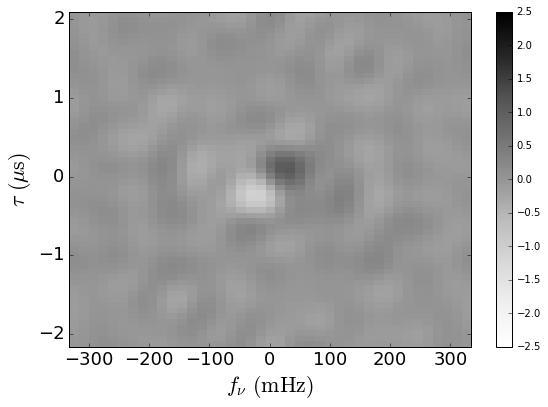

In [71]:
plt.figure(figsize=(9,6))

plt.imshow(np.imag(SS[fnu_slice, tau_slice]).T, interpolation='nearest', cmap = cm.Greys, aspect='auto',
          extent=[fnu[fnu_slice][0], fnu[fnu_slice][-1], tau[tau_slice][0], tau[tau_slice][-1]],
          vmax=2.5, vmin=-2.5)
plt.colorbar()

plt.xlabel(r'$f_{\nu}\ \mathrm{(mHz)}$', fontsize=22)
plt.ylabel(r'$\tau \ \mathrm{(\mu s)}$', fontsize=22)

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

if figures:
    plt.savefig('%sIPSS-imag.pdf' % (plotdir))

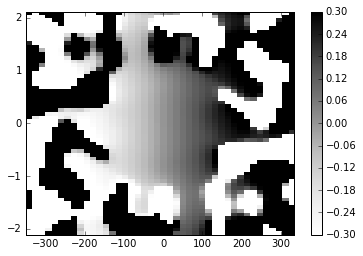

In [167]:
plt.imshow(np.angle(SS[fnu_slice, tau_slice]).T, interpolation='nearest', cmap = cm.Greys, aspect='auto',
          extent=[fnu[fnu_slice][0], fnu[fnu_slice][-1], tau[tau_slice][0], tau[tau_slice][-1]],
          vmax=0.3, vmin=-0.3)
plt.colorbar()

100%|██████████| 13037/13037 [02:02<00:00, 106.86it/s]


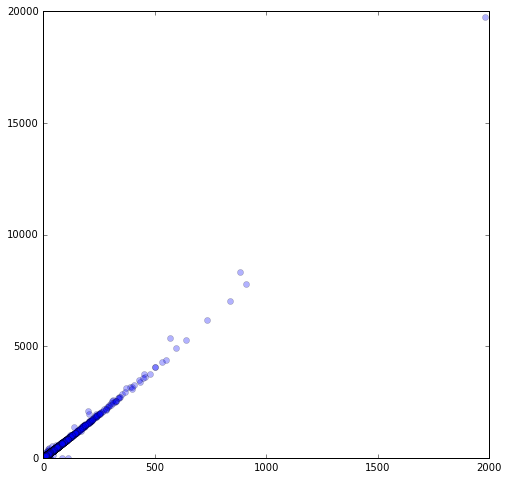

In [454]:
gplist = 'gp.txt'
T, SN, phase = ReadPulselist(gplist, SNcut=10, phase0=0.73, phasewidth=0.02)  #MP pairs
Jy = np.zeros_like(T)
Tsys = 165

for i in tqdm(range(len(T))):
    x = ReadP(T[i])
    xp = x.mean(-1)
    x_Tsys = xp / np.median(xp) - 1
    try:
        x_Jy = x_Tsys[50] * Tsys
    except:
        x_Jy = 0
    Jy[i] = x_Jy

plt.figure(figsize=(8,8))
plt.plot(SN, Jy, 'bo', alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')


7.57072254431


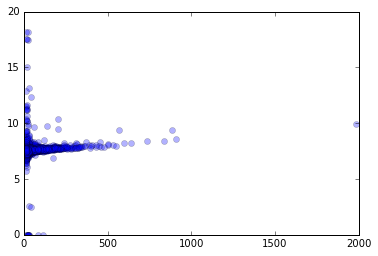

In [459]:
plt.plot(SN, Jy/SN, 'bo', alpha=0.3)

JyConv = np.mean(Jy/SN)
print JyConv


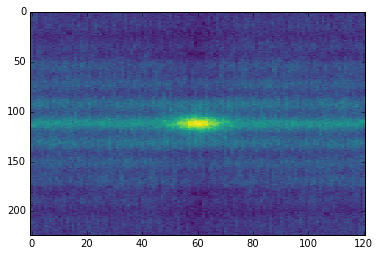

In [8]:
MPplot = np.load('MPcorr-SN1-1s.npy')

plt.imshow(MPplot.T)

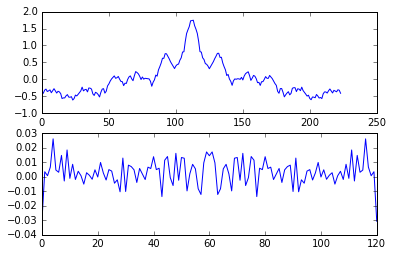

In [43]:
plt.subplot(211)
plt.plot(CCplot.sum(0))

plt.subplot(212)
plt.plot(CCplot[:, 1:].sum(1))


In [ ]:
def FreqCorr(GP1, N1, GP2, N2):
    N = len(GP1)
    ccorr = np.zeros(N)
    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    autoc = np.fft.irfft( np.fft.rfft(GP1 - np.mean(GP1))  * np.fft.rfft(GP2 - np.mean(GP2)).conj() )
    ccorr = autoc / np.sqrt(std1 * std2) / N
    return ccorr

GP2, N2 = ExtractPulse(T[j-5])

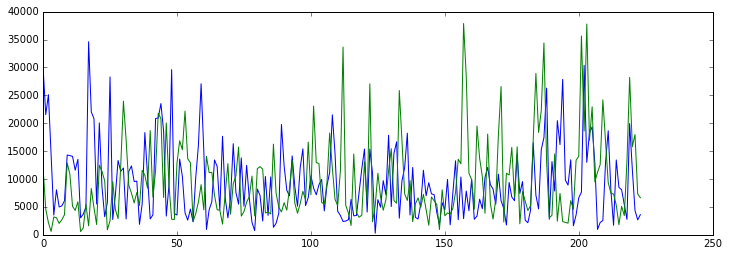

In [30]:
plt.figure(figsize=(12,4))

plt.plot(GP1)
plt.plot(GP2)

68.1871600151


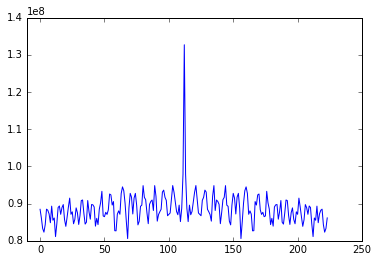

In [38]:
corr = np.zeros(len(GP1))

for i in range(len(GP1)):
    p1 = np.array(GP1)
    p2 = np.roll(GP1, i)
    corr[i] = np.mean(p1*p2)
    
corr = np.fft.fftshift(corr)

plt.xlim(-10, 250)
plt.plot(corr)

t1 = T[0]
t2 = T[3]

dt = t2.unix - t1.unix
print dt

(224,)
(224,)
[ -3.81639165e-17   9.48240616e-02   1.07073310e-01   1.27548735e-01
  -3.75888803e-02   3.05490761e-02   8.83220969e-02   1.32825622e-01
   2.59285416e-02  -7.48247794e-02  -1.16279410e-01  -6.12615365e-02
  -1.78393528e-02  -1.12263261e-01  -1.01218347e-01  -2.26926512e-02
   8.25449142e-02   1.04114762e-01   1.27142448e-02   8.13331287e-03
   1.64682451e-01   1.39056054e-01   1.08692510e-01   1.52824560e-01
   2.18052279e-01  -2.83512006e-03  -7.47639950e-02  -1.02963030e-01
   2.72876096e-02  -2.92703366e-02   1.08103662e-01   2.83177937e-02
   1.44271804e-01   5.13617451e-02   5.32605944e-02  -2.01052621e-02
   7.92689587e-02   1.30688581e-01   2.10530101e-01   2.05882039e-01
   1.75708441e-01   6.31265893e-03   1.13764115e-02  -4.60027192e-02
  -5.88872270e-03   8.20896493e-02   2.75784840e-01   2.49322561e-01
   1.15374870e-01   8.05976885e-02   6.15968689e-02  -1.63807820e-01
  -1.95615826e-01   3.17708838e-02   1.68526982e-01   7.52695265e-02
   7.21159517e-02   

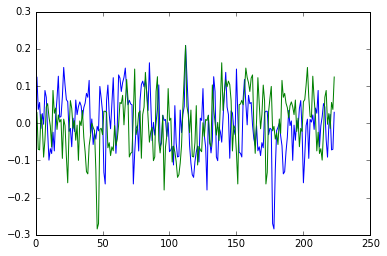

In [27]:
a = FreqCorr(GP1, N1, GP2, N2)
b = FreqCorr1(GP2, N2, GP1, N1)

plt.plot(a)
plt.plot(b)

print GP1.shape
print a.shape

print a-b

0.0293404186998 0.0293404186998


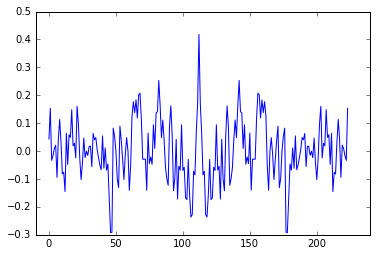

In [48]:
plt.plot( b+a)
plt.xlim(-10,240)

print b[1], a[-1]

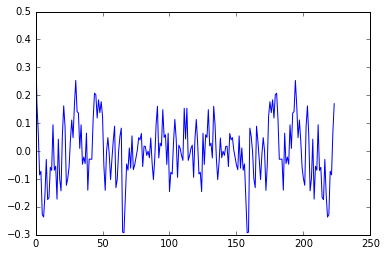

In [51]:
s = np.fft.fftshift(a)
t = np.fft.fftshift(b)

plt.plot(s+t)

In [ ]:
gplist = 'gp.txt'
SNcut = 4
T, SN, phase = ReadPulselist(gplist, SNcut=SNcut, phase0=0.5, phasewidth=0.5)

Tu = T.unix
DTu = np.diff(Tu)

t_dupes = np.argwhere(DTu < 1e-3).squeeze()

for i in range(len(t_dupes)):
    if SN[t_dupes[i]] > SN[t_dupes[i] + 1]:
        t_dupes[i] += 1

SN_dupes = SN[DTu < 1e-3]

T = np.delete(T, t_dupes)
SN = np.delete(SN, t_dupes)
phase = np.delete(phase, t_dupes)

print len(T)

[  3.21248327e+02   9.23583125e-03  -8.16410226e-02]


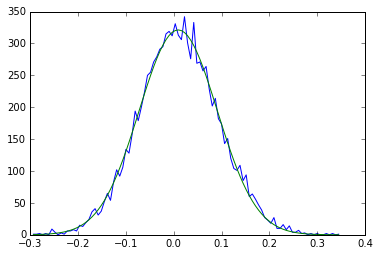

In [37]:
def gaussian(t, A, t0, tsig):
    g =  A * np.exp(-(t-t0)**2.0 / (2*tsig**2.0))
    return g

import scipy.optimize as so

p0 = [0.01, 0, 0.1]

a, edges = np.histogram(sims[:,1], bins=100)

b, berr = so.curve_fit(gaussian, edges[1:], a, p0=p0)

print b

plt.plot(edges[1:], a)
plt.plot(edges[1:], gaussian(edges[1:], b[0], b[1], b[2]))


[  2.89075233e+02   2.51675215e-02  -5.49127498e-01]


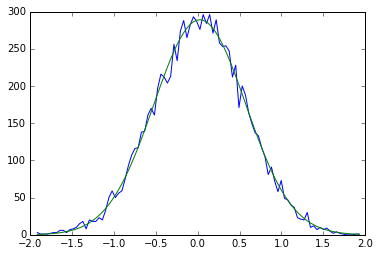

In [38]:
p0 = [0.01, 0, 0.1]

a, edges = np.histogram(sims[:,0], bins=100)

b, berr = so.curve_fit(gaussian, edges[1:], a, p0=p0)

print b

plt.plot(edges[1:], a)
plt.plot(edges[1:], gaussian(edges[1:], b[0], b[1], b[2]))

38536


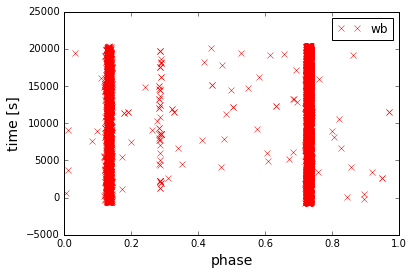

In [40]:
# SN=700 for 5 MPs, 250 for 5 IPs

SNcut = 6

T, SN, phase = np.loadtxt('gp.txt', dtype='string').T

T = Time(T, precision=9)
SN = SN.astype('float')
phase = phase.astype('float')

T = T[SN > SNcut]
phase = phase[SN > SNcut]
SN = SN[SN > SNcut]

print len(SN)

plt.plot(phase, T.unix - T[0].unix, 'rx', label='wb')

plt.xlim(0,1)
plt.ylabel('time [s]', fontsize=14)
plt.xlabel('phase', fontsize=14)

plt.legend()

In [41]:
Tu, indeces = np.unique(T.isot, return_index=True)
Tu = Time(Tu, precision=9)
SNu = SN[indeces]
phaseu = phase[indeces]

MPT = Tu[abs(phaseu-0.73)<0.05]
MPSN = SNu[abs(phaseu-0.73)<0.05]
MPphase = phaseu[abs(phaseu-0.73)<0.05]

IPT = Tu[abs(phaseu-0.15)<0.05]
IPSN = SNu[abs(phaseu-0.15)<0.05]
IPphase = phaseu[abs(phaseu-0.15)<0.05]

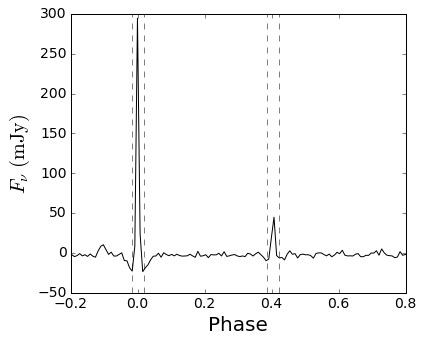

In [42]:
n2 = np.load('/home/ramain/trials/CrabAstron/wb/CrabWB-summedfs.npy')

P = 33*u.ms
gm1 = 23.5*u.ms / P
gm2 = 24.7*u.ms / P

gi1 = 3.8*u.ms / P
gi2 = 5.0*u.ms / P

Tsys = 165 # (Jansky)

njy = (n2 - 1) * Tsys * 1000

plt.figure(figsize=(6,5))

# Rejigging for plot

njy2 = np.concatenate((njy, njy))
pshift = 0.27

foldphase = np.linspace(-1,1,256)
foldphase += pshift

plt.plot(foldphase, njy2, 'k')
#plt.ylim(-0.1,1.1)
plt.axvline(gm1 + pshift - 1, color='k', ls='--', linewidth=0.5)
plt.axvline(gm2 + pshift - 1, color='k', ls='--', linewidth=0.5)
plt.axvline(gi1 + pshift, color='k', ls='--', linewidth=0.5)
plt.axvline(gi2 + pshift, color='k', ls='--', linewidth=0.5)

plt.xlabel('Phase', fontsize=20)
plt.ylabel(r'$F_{\nu}\ \mathrm{(mJy)}$', fontsize=20)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.xlim(-0.2, 0.8)

if figures:
    plt.savefig('%sFoldspec.pdf' % (plotdir), dpi=500)

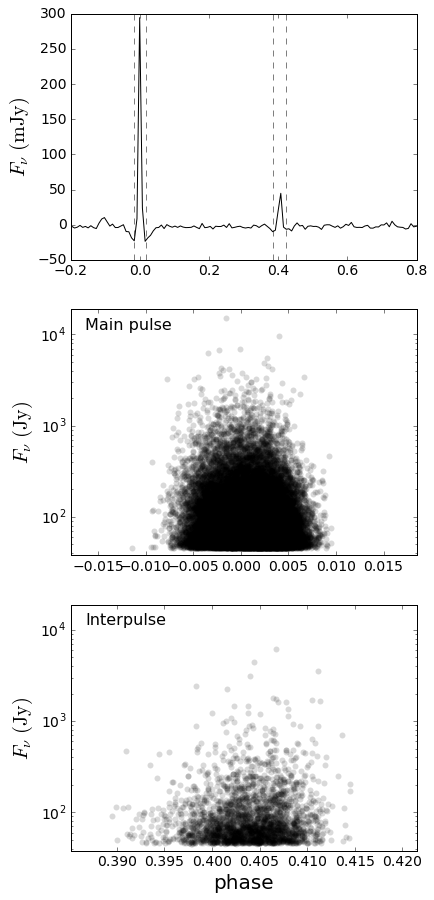

In [43]:
JyConv = 7.57072254431

plt.figure(figsize=(6.2,15))

""" Folded Profile """
plt.subplot(311)

plt.plot(foldphase, njy2, 'k')
#plt.ylim(-0.1,1.1)
plt.axvline(gm1 + pshift - 1, color='k', ls='--', linewidth=0.5)
plt.axvline(gm2 + pshift - 1, color='k', ls='--', linewidth=0.5)
plt.axvline(gi1 + pshift, color='k', ls='--', linewidth=0.5)
plt.axvline(gi2 + pshift, color='k', ls='--', linewidth=0.5)

#plt.xlabel('Phase', fontsize=20)
plt.ylabel(r'$F_{\nu}\ \mathrm{(mJy)}$', fontsize=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.xlim(-0.2, 0.8)

""" Main Pulses """
plt.subplot(312)

plt.plot(phaseu + pshift - 1, SNu*JyConv, 'ko', alpha=0.15, markeredgecolor = 'none')

plt.xlim(23.5 / 33 + pshift - 1, 24.7 / 33 + pshift - 1)
plt.ylim(5*JyConv, 2500*JyConv)
plt.yscale('log')
plt.text(23.55 / 33 + pshift - 1 , 1500*JyConv, 'Main pulse', fontsize=16)
plt.ylabel(r'$F_{\nu}\ \mathrm{(Jy)}$', fontsize=20)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

""" Interpulses """
plt.subplot(313)

plt.plot(phaseu  + pshift , SNu*JyConv, 'ko', alpha=0.15, markeredgecolor = 'none')
plt.xlim(3.8 / 33  + pshift, 5. / 33  + pshift)
plt.ylim(5*JyConv, 2500*JyConv)
plt.yscale('log')
plt.text(3.85 / 33 + pshift, 1500*JyConv, 'Interpulse', fontsize=16)
plt.xlabel('phase', fontsize=20)
plt.ylabel(r'$F_{\nu}\ \mathrm{(Jy)}$', fontsize=20)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)


if figures:
    plt.savefig('%sMP_IP_SN.pdf' % (plotdir), dpi=500)

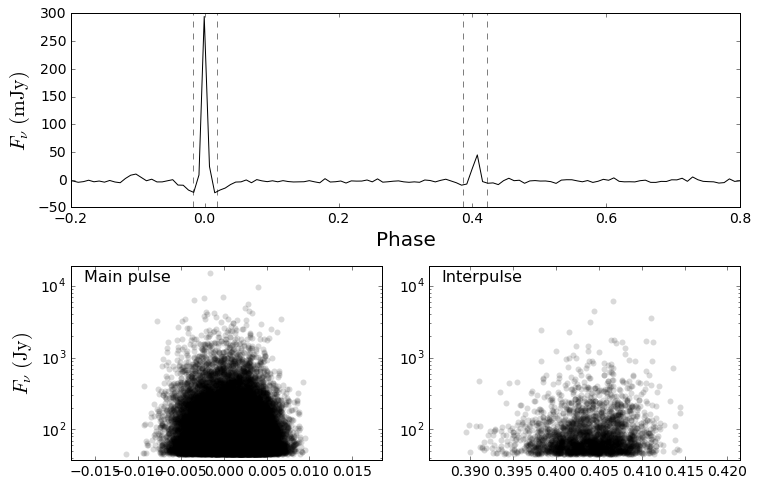

In [73]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12, 8))

AX = gridspec.GridSpec(2,2)
AX.update(wspace = 0.15, hspace = 0.3)

ax1 = plt.subplot(AX[0,:])
ax2 = plt.subplot(AX[1,0])
ax3 = plt.subplot(AX[1,1])

#ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
#ax2 = plt.subplot2grid((2,2), (1,0))
#ax3 = plt.subplot2grid((2,2), (1,1))


ax1.plot(foldphase, njy2, 'k')
#plt.ylim(-0.1,1.1)
ax1.axvline(gm1 + pshift - 1, color='k', ls='--', linewidth=0.5)
ax1.axvline(gm2 + pshift - 1, color='k', ls='--', linewidth=0.5)
ax1.axvline(gi1 + pshift, color='k', ls='--', linewidth=0.5)
ax1.axvline(gi2 + pshift, color='k', ls='--', linewidth=0.5)

ax1.set_xlabel('Phase', fontsize=20)
ax1.set_ylabel(r'$F_{\nu}\ \mathrm{(mJy)}$', fontsize=20)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlim(-0.2, 0.8)


ax2.plot(phaseu + pshift - 1, SNu*JyConv, 'ko', alpha=0.15, markeredgecolor = 'none')
ax2.set_xlim(23.5 / 33 + pshift - 1, 24.7 / 33 + pshift - 1)
ax2.set_ylim(5*JyConv, 2500*JyConv)
ax2.set_yscale('log')
ax2.text(23.55 / 33 + pshift - 1 , 1500*JyConv, 'Main pulse', fontsize=16)
ax2.set_ylabel(r'$F_{\nu}\ \mathrm{(Jy)}$', fontsize=20)

ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

""" Interpulses """

ax3.plot(phaseu  + pshift , SNu*JyConv, 'ko', alpha=0.15, markeredgecolor = 'none')
ax3.set_xlim(3.8 / 33  + pshift, 5. / 33  + pshift)
ax3.set_ylim(5*JyConv, 2500*JyConv)
ax3.set_yscale('log')
ax3.text(3.85 / 33 + pshift, 1500*JyConv, 'Interpulse', fontsize=16)

ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)


if figures:
    plt.savefig('%sMP_IP_SN.pdf' % (plotdir), dpi=500)

In [87]:
"""
Create Profiles of MPs
"""

MPT, MPSN, NPphase = ReadPulselist('gp.txt', SNcut=1000, phase0=0.73, phasewidth=0.02) # 2 brightest MP
#MPT, MPSN, NPphase = ReadPulselist('gp.txt', SNcut=500, phase0=0.15, phasewidth=0.05)  # 2 brightest IP

from descatter_tools.descatter_tools import *

for tgp in MPT:

    dchan = np.load('/media/drive2/GPs16/GP%s.npy' % (tgp))
    dchan = rechannelize(dchan,4)
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)[1500:1900]
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)[1500:1900]
    peak = np.argmax(abs(dR).sum(-1) + abs(dL).sum(-1))
                     
    dL = np.roll(dL, 200-peak, axis=0)
    dR = np.roll(dR, 200-peak, axis=0)
    
    I, Q, U, V = Stokes(dR, dL)
    
    L = Q + 1j*U
    Lb = L.reshape(-1,4,8).mean(axis=1)
    
    xp = np.linspace(-50,50,401)[:-1]
    xb = np.linspace(-50,50,101)[:-1]
    
    
    plt.figure(figsize=(10,4))
    #plt.subplot(211)
    plt.plot(xp, I.sum(1) - I.sum(1)[:40].mean(0), 'k', label='I')
    plt.plot(xp, abs(L).sum(1) - abs(L).sum(1)[:40].mean(0), 'r', label='|L|')
    plt.plot(xp, V.sum(1) - V.sum(1)[:40].mean(0), 'b', label='V')
    #plt.legend()
    #plt.ylabel('Intensity')
    
    plt.xlim(-10,20)
    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.savefig('%sCrabWb_GP%s-new.pdf' % (plotdir, int(tgp.unix)))
    plt.clf()
    

In [88]:
freq = np.linspace(1652, 1652+32, 256+1)[:-1]

for tgp in MPT:

    dchan = np.load('/media/drive2/GPs16/GP%s.npy' % (tgp))
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    I, Q, U, V = Stokes(dR, dL)
    
    pulse = I[49:53].mean(0)
    bg = I[10:30].mean(0)
    GP=(pulse - bg)
    
    plt.figure(figsize=(10,4))
    #plt.subplot(211)
    plt.plot(freq, GP, 'k')
        
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.savefig('%sCrabWb_GPspec%s-new.pdf' % (plotdir, int(tgp.unix)))
    plt.clf()